In [ ]:
# connect to drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Introduction 

We focus on the problem of Unsupervised Domain Adaptation. It consists in learning a good classifier in a target domain (without access to labelled training data) by using labelled data from a related, but different, source domain and unlabelled data from the target domain.

In this session, we will learn domain invariant representations for performing unsupervised domain adaptation. 

## Unsupervised Domain Adaptation by Backpropagation

http://proceedings.mlr.press/v37/ganin15.html

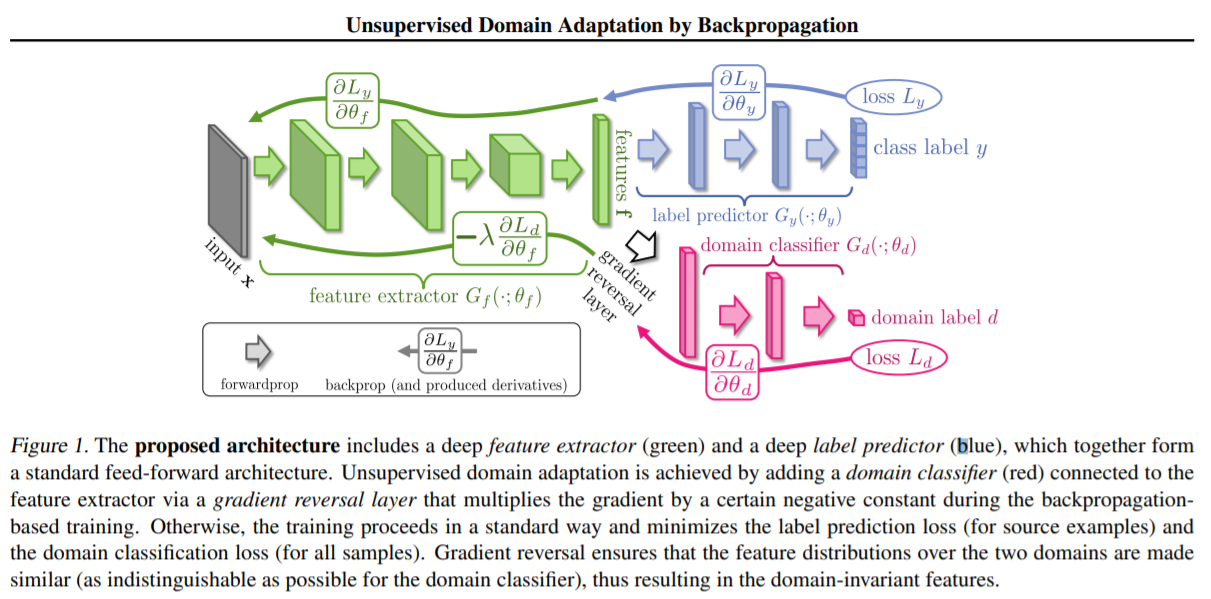

## Office31 datasets

We focus on 1 of the 12 tasks of the Office31 dataset: Amazon -> Webcam. Note that it exists many other, and more challenging, datasets e.g. Office-Home, VisDA or DomainNet. 

You can download the dataset here: https://drive.google.com/open?id=0B4IapRTv9pJ1WGZVd1VDMmhwdlE

In the directory of the session on colab, you should put in 
data/office/domain_adaptation_images/ the images of Amazon and Webcam in the respective directory. This may take several minutes...

You are invited to visualize the images and observe how Amazon and Webcam domains are different.

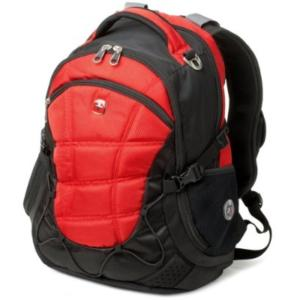

frame_0001.jpg

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

You have to import the good directory.

In [ ]:
import os 

os.chdir('drive/My Drive/session_7/pytorch')

## Cells you must no modify

The notebook is inspired from the following repo https://github.com/thuml/CDAN/. There are many functions needed for running properly it, so do not modify the following sections: 
- Preprocess
- Data List
- Loss
- Lr Schedule
- Networks
- Test Images



# Preprocess
DO NOT MODIFY

In [ ]:
import numpy as np
from torchvision import transforms
import os
from PIL import Image, ImageOps
import numbers
import torch

class ResizeImage():
    def __init__(self, size):
      if isinstance(size, int):
        self.size = (int(size), int(size))
      else:
        self.size = size
    def __call__(self, img):
      th, tw = self.size
      return img.resize((th, tw))

class RandomSizedCrop(object):
    """Crop the given PIL.Image to random size and aspect ratio.
    A crop of random size of (0.08 to 1.0) of the original size and a random
    aspect ratio of 3/4 to 4/3 of the original aspect ratio is made. This crop
    is finally resized to given size.
    This is popularly used to train the Inception networks.
    Args:
        size: size of the smaller edge
        interpolation: Default: PIL.Image.BILINEAR
    """

    def __init__(self, size, interpolation=Image.BILINEAR):
        self.size = size
        self.interpolation = interpolation

    def __call__(self, img):
        h_off = random.randint(0, img.shape[1]-self.size)
        w_off = random.randint(0, img.shape[2]-self.size)
        img = img[:, h_off:h_off+self.size, w_off:w_off+self.size]
        return img


class Normalize(object):
    """Normalize an tensor image with mean and standard deviation.
    Given mean: (R, G, B),
    will normalize each channel of the torch.*Tensor, i.e.
    channel = channel - mean
    Args:
        mean (sequence): Sequence of means for R, G, B channels respecitvely.
    """

    def __init__(self, mean=None, meanfile=None):
        if mean:
            self.mean = mean
        else:
            arr = np.load(meanfile)
            self.mean = torch.from_numpy(arr.astype('float32')/255.0)[[2,1,0],:,:]

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        # TODO: make efficient
        for t, m in zip(tensor, self.mean):
            t.sub_(m)
        return tensor



class PlaceCrop(object):
    """Crops the given PIL.Image at the particular index.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (w, h), a square crop (size, size) is
            made.
    """

    def __init__(self, size, start_x, start_y):
        if isinstance(size, int):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.start_x = start_x
        self.start_y = start_y

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be cropped.
        Returns:
            PIL.Image: Cropped image.
        """
        th, tw = self.size
        return img.crop((self.start_x, self.start_y, self.start_x + tw, self.start_y + th))


class ForceFlip(object):
    """Horizontally flip the given PIL.Image randomly with a probability of 0.5."""

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.
        Returns:
            PIL.Image: Randomly flipped image.
        """
        return img.transpose(Image.FLIP_LEFT_RIGHT)

class CenterCrop(object):
    """Crops the given PIL.Image at the center.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
    """

    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be cropped.
        Returns:
            PIL.Image: Cropped image.
        """
        w, h = (img.shape[1], img.shape[2])
        th, tw = self.size
        w_off = int((w - tw) / 2.)
        h_off = int((h - th) / 2.)
        img = img[:, h_off:h_off+th, w_off:w_off+tw]
        return img


def image_train(resize_size=256, crop_size=224, alexnet=False):
  if not alexnet:
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
  else:
    normalize = Normalize(meanfile='./ilsvrc_2012_mean.npy')
  return  transforms.Compose([
        ResizeImage(resize_size),
        transforms.RandomResizedCrop(crop_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])

def image_test(resize_size=256, crop_size=224, alexnet=False):
  if not alexnet:
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
  else:
    normalize = Normalize(meanfile='./ilsvrc_2012_mean.npy')
  start_first = 0
  start_center = (resize_size - crop_size - 1) / 2
  start_last = resize_size - crop_size - 1
 
  return transforms.Compose([
    ResizeImage(resize_size),
    PlaceCrop(crop_size, start_center, start_center),
    transforms.ToTensor(),
    normalize
  ])

def image_test_10crop(resize_size=256, crop_size=224, alexnet=False):
    if not alexnet:
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
    else:
        normalize = Normalize(meanfile='./ilsvrc_2012_mean.npy')
    start_first = 0
    start_center = (resize_size - crop_size - 1) / 2
    start_last = resize_size - crop_size - 1
    data_transforms = [
        transforms.Compose([
        ResizeImage(resize_size),ForceFlip(),
        PlaceCrop(crop_size, start_first, start_first),
        transforms.ToTensor(),
        normalize
        ]),
        transforms.Compose([
        ResizeImage(resize_size),ForceFlip(),
        PlaceCrop(crop_size, start_last, start_last),
        transforms.ToTensor(),
        normalize
        ]),
        transforms.Compose([
        ResizeImage(resize_size),ForceFlip(),
        PlaceCrop(crop_size, start_last, start_first),
        transforms.ToTensor(),
        normalize
        ]),
        transforms.Compose([
        ResizeImage(resize_size),ForceFlip(),
        PlaceCrop(crop_size, start_first, start_last),
        transforms.ToTensor(),
        normalize
        ]),
        transforms.Compose([
        ResizeImage(resize_size),ForceFlip(),
        PlaceCrop(crop_size, start_center, start_center),
        transforms.ToTensor(),
        normalize
        ]),
        transforms.Compose([
        ResizeImage(resize_size),
        PlaceCrop(crop_size, start_first, start_first),
        transforms.ToTensor(),
        normalize
        ]),
        transforms.Compose([
        ResizeImage(resize_size),
        PlaceCrop(crop_size, start_last, start_last),
        transforms.ToTensor(),
        normalize
        ]),
        transforms.Compose([
        ResizeImage(resize_size),
        PlaceCrop(crop_size, start_last, start_first),
        transforms.ToTensor(),
        normalize
        ]),
        transforms.Compose([
        ResizeImage(resize_size),
        PlaceCrop(crop_size, start_first, start_last),
        transforms.ToTensor(),
        normalize
        ]),
        transforms.Compose([
        ResizeImage(resize_size),
        PlaceCrop(crop_size, start_center, start_center),
        transforms.ToTensor(),
        normalize
        ])
    ]
    return data_transforms


# Data List
DO NOT MODIFY

In [ ]:
import torch
import numpy as np
import random
from PIL import Image
from torch.utils.data import Dataset
import os
import os.path

def make_dataset(image_list, labels):
    if labels:
      len_ = len(image_list)
      images = [(image_list[i].strip(), labels[i, :]) for i in range(len_)]
    else:
      if len(image_list[0].split()) > 2:
        images = [(val.split()[0], np.array([int(la) for la in val.split()[1:]])) for val in image_list]
      else:
        images = [(val.split()[0], int(val.split()[1])) for val in image_list]
    return images


def rgb_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

def l_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('L')

class ImageList(Dataset):
    def __init__(self, image_list, labels=None, transform=None, target_transform=None, mode='RGB'):
        imgs = make_dataset(image_list, labels)
        if len(imgs) == 0:
            raise(RuntimeError("Found 0 images in subfolders of: " + root + "\n"
                               "Supported image extensions are: " + ",".join(IMG_EXTENSIONS)))

        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform
        if mode == 'RGB':
            self.loader = rgb_loader
        elif mode == 'L':
            self.loader = l_loader

    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.imgs)

class ImageValueList(Dataset):
    def __init__(self, image_list, labels=None, transform=None, target_transform=None,
                 loader=rgb_loader):
        imgs = make_dataset(image_list, labels)
        if len(imgs) == 0:
            raise(RuntimeError("Found 0 images in subfolders of: " + root + "\n"
                               "Supported image extensions are: " + ",".join(IMG_EXTENSIONS)))

        self.imgs = imgs
        self.values = [1.0] * len(imgs)
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    def set_values(self, values):
        self.values = values

    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.imgs)

# Loss

Implement them when needed.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import math
import torch.nn.functional as F
import pdb

import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import math
import torch.nn.functional as F
import pdb

CUDA = True


def Entropy(input_):
    #TODO
    return entropy

def DANN(features, ad_net):
    ad_out = ad_net(features)
    batch_size = ad_out.size(0) // 2
    
    dc_target = torch.from_numpy(np.array([[1]] * batch_size + [[0]] * batch_size)).float()
    if CUDA:
        dc_target = dc_target.cuda()

    return #TODO

# LR schedule 
DO NOT MODIFY

In [ ]:
def inv_lr_scheduler(optimizer, iter_num, gamma, power, lr=0.001, weight_decay=0.0005):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = lr * (1 + gamma * iter_num) ** (-power)
    i=0
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr * param_group['lr_mult']
        param_group['weight_decay'] = weight_decay * param_group['decay_mult']
        i+=1

    return optimizer


schedule_dict = {"inv": inv_lr_scheduler}

# Networks

The Gradient Reversal Layer must be implemented for DANN

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.autograd import Variable
import math
import pdb

def calc_coeff(iter_num, high=1.0, low=0.0, alpha=10.0, max_iter=10000.0):
    return np.float(2.0 * (high - low) / (1.0 + np.exp(-alpha*iter_num / max_iter)) - (high - low) + low)


def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1 or classname.find('ConvTranspose2d') != -1:
        nn.init.kaiming_uniform_(m.weight)
        nn.init.zeros_(m.bias)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.zeros_(m.bias)
    elif classname.find('Linear') != -1:
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)


resnet_dict = {"ResNet18":models.resnet18, "ResNet34":models.resnet34, "ResNet50":models.resnet50, "ResNet101":models.resnet101, "ResNet152":models.resnet152}

def grl_hook(coeff):
    def fun1(grad):
        return -coeff*grad.clone()
    return fun1

class ResNetFc(nn.Module):
  def __init__(self, use_bottleneck=True, bottleneck_dim=256, class_num=31):
    super(ResNetFc, self).__init__()
    model_resnet = models.resnet50(pretrained=True)
    self.conv1 = model_resnet.conv1
    self.bn1 = model_resnet.bn1
    self.relu = model_resnet.relu
    self.maxpool = model_resnet.maxpool
    self.layer1 = model_resnet.layer1
    self.layer2 = model_resnet.layer2
    self.layer3 = model_resnet.layer3
    self.layer4 = model_resnet.layer4
    self.avgpool = model_resnet.avgpool
    self.feature_layers = nn.Sequential(self.conv1, self.bn1, self.relu, self.maxpool, \
                         self.layer1, self.layer2, self.layer3, self.layer4, self.avgpool)

    self.use_bottleneck = use_bottleneck

    if self.use_bottleneck:
        self.bottleneck = nn.Linear(model_resnet.fc.in_features, bottleneck_dim)
        self.fc = nn.Linear(bottleneck_dim, class_num)
        self.bottleneck.apply(init_weights)
        self.fc.apply(init_weights)
        self.__in_features = bottleneck_dim
    else:
        self.fc = nn.Linear(model_resnet.fc.in_features, class_num)
        self.fc.apply(init_weights)
        self.__in_features = model_resnet.fc.in_features


  def forward(self, x):
    x = self.feature_layers(x)
    x = x.view(x.size(0), -1)
    if self.use_bottleneck:
        x = self.bottleneck(x)
    y = self.fc(x)
    return x, y

  def output_num(self):
    return self.__in_features

  def get_parameters(self):
    if self.use_bottleneck:
        parameter_list = [{"params":self.feature_layers.parameters(), "lr_mult":1, 'decay_mult':2}, \
                          {"params":self.bottleneck.parameters(), "lr_mult":10, 'decay_mult':2}, \
                          {"params":self.fc.parameters(), "lr_mult":10, 'decay_mult':2}]
    else:
        parameter_list = [{"params":self.feature_layers.parameters(), "lr_mult":1, 'decay_mult':2}, \
                          {"params":self.fc.parameters(), "lr_mult":10, 'decay_mult':2}]
    return parameter_list


class AdversarialNetwork(nn.Module):
  def __init__(self, in_feature, hidden_size, output_dim=1):
    super(AdversarialNetwork, self).__init__()
    self.ad_layer1 = nn.Linear(in_feature, hidden_size)
    self.ad_layer2 = nn.Linear(hidden_size, hidden_size)
    self.ad_layer3 = nn.Linear(hidden_size, output_dim)

    self.relu1 = nn.ReLU()
    self.relu2 = nn.ReLU()
    self.dropout1 = nn.Dropout(0.5)
    self.dropout2 = nn.Dropout(0.5)
    self.sigmoid = nn.Sigmoid()
    self.apply(init_weights)
    self.iter_num = 0
    self.alpha = 10
    self.low = 0.0
    self.high = 1.0
    self.max_iter = 10000.0
    self.output_dim = output_dim

  def forward(self, x):
    if self.training:
        self.iter_num += 1
    
    coeff = calc_coeff(self.iter_num, self.high, self.low, self.alpha, self.max_iter)
    x = x * 1.0
    
    # Gradient Reversal Layer
    x.register_hook(
        #TODO
        )


    x = self.ad_layer1(x)
    x = self.relu1(x)
    x = self.dropout1(x)
    x = self.ad_layer2(x)
    x = self.relu2(x)
    x = self.dropout2(x)
    
    d = self.ad_layer3(x)
    return self.sigmoid(d)

  def get_parameters(self):
    return [{"params": self.parameters(), "lr_mult": 10, 'decay_mult': 2}]

# Test Images
DO NOT MODIFY

Computes the accuracy based on 10 cropped augmentation of images

In [ ]:
def image_classification_test(data_loader_test, model, test_10crop=True):
    start_test = True
    with torch.no_grad():
        iter_test = [iter(data_loader_test[i]) for i in range(10)]
        for i in range(len(data_loader_test[0])):
            data = [iter_test[j].next() for j in range(10)]
            inputs = [data[j][0] for j in range(10)]
            labels = data[0][1]
            for j in range(10):
                if CUDA:
                    inputs[j] = inputs[j].cuda()
            labels = labels
            outputs = []
            for j in range(10):
                _, predict_out = model(inputs[j])
                outputs.append(nn.Softmax(dim=1)(predict_out))
            outputs = sum(outputs)
            if start_test:
                all_output = outputs.float().cpu()
                all_label = labels.float()
                start_test = False
            else:
                all_output = torch.cat((all_output, outputs.float().cpu()), 0)
                all_label = torch.cat((all_label, labels.float()), 0)
        del iter_test, data, inputs, labels

    _, predict = torch.max(all_output, 1)
    accuracy = torch.sum(torch.squeeze(predict).float() == all_label).item() / float(all_label.size()[0])
    del predict, all_output, all_label
    return accuracy

# Train Images

## Training on source domain (no adaptation)

In [ ]:
import os
import os.path as osp

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
import random
import pdb
import math
from tqdm import tqdm_notebook as tqdm

def train(config):
    
    ## set pre-process
    prep_dict = {}
    prep_config = config["prep"]
    prep_dict["source"] = image_train(**config["prep"]['params'])
    prep_dict["target"] = image_train(**config["prep"]['params'])
    if prep_config["test_10crop"]:
        prep_dict["test"] = image_test_10crop(**config["prep"]['params'])
    else:
        prep_dict["test"] = image_test(**config["prep"]['params'])

    ## prepare data
    dsets = {}
    dset_loaders = {}
    data_config = config["data"]
    train_bs = 32
    test_bs = 32

    # Prepare source data
    data_source = ImageList(
        open(data_config["source"]["list_path"]).readlines(), 
        transform=prep_dict["source"]
        )
    
    data_loader_source = DataLoader(data_source, 
                                    batch_size=train_bs, 
                                    shuffle=True, 
                                    num_workers=4, 
                                    drop_last=True)
    
    data_test = [
                 ImageList(open(
                     data_config["test"]["list_path"]).readlines(), 
                     transform=prep_dict["test"][i]
                     ) 
                 for i in range(10)
                 ]

    data_loader_test = [
                        DataLoader(d, 
                                   batch_size=test_bs, 
                                   shuffle=False, num_workers=4
                                   ) 
                        for d in data_test
                        ]

    # Set the backbone network
    base_network = ResNetFc()
    base_network = base_network.cuda()      
    
    # Get trainable paramters for both backbone and and adversarial network
    parameter_list = base_network.get_parameters()

    ## set optimizer
    optimizer_config = config["optimizer"]
    optimizer = optimizer_config["type"](parameter_list, **(optimizer_config["optim_params"]))

    param_lr = []
    for param_group in optimizer.param_groups:
        param_lr.append(param_group["lr"])
    schedule_param = optimizer_config["lr_param"]
    lr_scheduler = schedule_dict[optimizer_config["lr_type"]]

    for i in tqdm(range(config["num_iterations"])):
        # Test at a given number of iterations
        if i % config["test_interval"] == config["test_interval"] - 1:

            base_network.eval()

            accuracy = image_classification_test(data_loader_test, 
                                                 base_network
                                                 )

            log_str = "iter: {:05d}, accuracy: {:.5f}".format(i, accuracy)
            print(log_str)

        ## train one iter
        base_network.train()
    
        # Schedule the learning rate
        optimizer = lr_scheduler(optimizer, i, **schedule_param)


        optimizer.zero_grad()

        try: 
          inputs_source, labels_source = iter_source.next()
        except: 
          iter_source = iter(data_loader_source)
          inputs_source, labels_source = iter_source.next()
        inputs_source, labels_source = inputs_source.cuda(), labels_source.cuda()

    
        features_source, outputs_source = base_network(inputs_source)
    
      
        # Compute loss
        classifier_loss = #TODO
        classifier_loss.backward()
        optimizer.step()

# train config
config = {}
config["num_iterations"] = 20000
config["test_interval"] = 500

config["prep"] = {"test_10crop":True, 'params':{"resize_size": 256, "crop_size": 224, 'alexnet':False}}

config["optimizer"] = {
    "type":optim.SGD, 
    "optim_params": {
        'lr':0.001, 
        "momentum": 0.9, 
        "weight_decay": 0.0005, 
        "nesterov":True
        }, 
    "lr_type":"inv",
    "lr_param": {
        "lr": 0.001, 
        "gamma": 0.001, 
        "power": 0.75
        }
  }

config["dataset"] = 'office' 
s_dset_path = '../data/office/amazon_list_local.txt' 
t_dset_path = '../data/office/webcam_list_local.txt'
test_dset_path = '../data/office/webcam_list_local.txt'

config["data"] = {
    "source": {"list_path": s_dset_path}, 
    "target": {"list_path":t_dset_path},
    "test": {"list_path":test_dset_path}
    }

train(config)

## Domain Adversarial Neural Network

In [ ]:
import os
import os.path as osp

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
import random
import pdb
import math
from tqdm import tqdm_notebook as tqdm

def train(config):
    
    ## set pre-process
    prep_dict = {}
    prep_config = config["prep"]
    prep_dict["source"] = image_train(**config["prep"]['params'])
    prep_dict["target"] = image_train(**config["prep"]['params'])
    if prep_config["test_10crop"]:
        prep_dict["test"] = image_test_10crop(**config["prep"]['params'])
    else:
        prep_dict["test"] = image_test(**config["prep"]['params'])

    ## prepare data
    dsets = {}
    dset_loaders = {}
    data_config = config["data"]
    train_bs = 32
    test_bs = 32

    # Prepare source data
    data_source = ImageList(
        open(data_config["source"]["list_path"]).readlines(), 
        transform=prep_dict["source"]
        )
    
    data_loader_source = DataLoader(data_source, 
                                    batch_size=train_bs, 
                                    shuffle=True, 
                                    num_workers=4, 
                                    drop_last=True)
    
    data_target = ImageList(
        open(data_config["target"]["list_path"]).readlines(),
        transform=prep_dict["target"]
        )
    
    data_loader_target = #TODO

    data_test = [
                 ImageList(open(
                     data_config["test"]["list_path"]).readlines(), 
                     transform=prep_dict["test"][i]
                     ) 
                 for i in range(10)
                 ]

    data_loader_test = [
                        DataLoader(d, 
                                   batch_size=test_bs, 
                                   shuffle=False, num_workers=4
                                   ) 
                        for d in data_test
                        ]

    # Set the backbone network
    base_network = ResNetFc()
    base_network = base_network.cuda()

    # Set the adversarial network
    ## Implement the Gradient Aversarial Layer in Networks
    ## Use hidden_dim = 1024

    ad_net = # TODO
    ad_net = ad_net.cuda()
          
    # Get trainable paramters for both backbone and and adversarial network
    parameter_list = # TODO

    ## set optimizer
    optimizer_config = config["optimizer"]
    optimizer = optimizer_config["type"](parameter_list, **(optimizer_config["optim_params"]))

    param_lr = []
    for param_group in optimizer.param_groups:
        param_lr.append(param_group["lr"])
    schedule_param = optimizer_config["lr_param"]
    lr_scheduler = schedule_dict[optimizer_config["lr_type"]]

    for i in tqdm(range(config["num_iterations"])):
        # Test at a given number of iterations
        if i % config["test_interval"] == config["test_interval"] - 1:

            base_network.eval()

            accuracy = image_classification_test(data_loader_test, 
                                                 base_network
                                                 )

            log_str = "iter: {:05d}, accuracy: {:.5f}".format(i, accuracy)
            print(log_str)

        ## train one iter
        base_network.train()
        ad_net.train()

        # Schedule the learning rate
        optimizer = lr_scheduler(optimizer, i, **schedule_param)


        optimizer.zero_grad()

        try: 
          inputs_source, labels_source = iter_source.next()
        except: 
          iter_source = iter(data_loader_source)
          inputs_source, labels_source = iter_source.next()
        inputs_source, labels_source = inputs_source.cuda(), labels_source.cuda()

        try:
          inputs_target, labels_target = iter_target.next()
        except:
          iter_target = iter(data_loader_target)
          inputs_target, labels_target = iter_target.next()
        inputs_target, labels_target = inputs_target.cuda(), labels_target.cuda()

        features_source, outputs_source = base_network(inputs_source)
        features_target, outputs_target = base_network(inputs_target)
        
        features = torch.cat((features_source, features_target), dim=0)

      
        # Compute loss
        classifier_loss = # TODO

        ## Implement DANN in Loss
        transfer_loss = DANN(features, ad_net)
        loss = classifier_loss + transfer_loss

        loss.backward()
        optimizer.step()


# train config
config = {}
config["num_iterations"] = 20000
config["test_interval"] = 500

config["prep"] = {"test_10crop":True, 'params':{"resize_size": 256, "crop_size": 224, 'alexnet':False}}

config["optimizer"] = {
    "type":optim.SGD, 
    "optim_params": {
        'lr':0.001, 
        "momentum": 0.9, 
        "weight_decay": 0.0005, 
        "nesterov":True
        }, 
    "lr_type":"inv",
    "lr_param": {
        "lr": 0.001, 
        "gamma": 0.001, 
        "power": 0.75
        }
  }

config["dataset"] = 'office' 
s_dset_path = '../data/office/amazon_list_local.txt' 
t_dset_path = '../data/office/webcam_list_local.txt'
test_dset_path = '../data/office/webcam_list_local.txt'

config["data"] = {
    "source": {"list_path": s_dset_path}, 
    "target": {"list_path":t_dset_path},
    "test": {"list_path":test_dset_path}
    }

train(config)

## Entropy regularization
Add an entropy regularization to the DANN